In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import supervision as sv
import cv2
import shapely as sp
import ultralytics
import shutil
import random as rd
from sklearn.metrics import confusion_matrix
from collections import namedtuple
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

In [10]:
pip install supervision shapely

Note: you may need to restart the kernel to use updated packages.


In [63]:
pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.1 MB 7.4 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.1 MB 6.0 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.1 MB 3.9 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/11.1 MB 3.9 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/11.1 MB 3.9 MB/s eta 0:00:02
   ---------------- ----------------------- 4.5/11.1 MB 3.8 MB/s eta 0:00:02
   ------------------- -------------------- 5.5/11.1 MB 3.9 MB/s eta 0:00:02
   ---------------------- ----------------- 6.3/11.1 MB 3.9 MB/s eta 0:00:02
   -------------------------- ------------- 7.3/11.1 MB 3.9 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.1 MB 3.9 MB/s eta 0:00:01
   -------------------------

In [2]:
labels = "labels/labels_native"
images = "image_chips_native"
output_path = "Outputs"

# Data Exploration and Understanding

In [3]:
#variables declaration
total_instances = 0
value_counts = {}
max_count = 0
image_size = 416
resolution = 0.31
instances_area = []
mean_area = 0
sd_area = 0

1. ## Dataset statistics 

In [5]:
for file_name in os.listdir(labels):
    if file_name.endswith(".txt"):
        file_path = os.path.join(labels, file_name)
        
        with open(file_path, "r") as file:
            
            lines = file.readlines()
            curr_file_len = len(lines) #length of the current opened file
            total_instances += curr_file_len
            value_counts[curr_file_len] = value_counts.get(curr_file_len, 0) + 1
            max_count = max(max_count, curr_file_len)

            for line in lines:
                curr_area = compute_area_instance(line)
                instances_area.append(curr_area)

for i in range(max_count + 1):
    if value_counts.get(i, 0) == 0:
        value_counts[i] = 0
        
mean_area = np.mean(instances_area)
sd_area = np.std(instances_area, dtype = np.float32)

- #### How many instances of solar panels are present in the dataset?
- #### Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

In [6]:
print(f"The Total number of instances of solar panels are present in the dataset: {total_instances}\n")

print("Value counts of labels per image:")
for values in range(1, max_count + 1):
    print(f"{value_counts[values]} images have {values} labels")

The Total number of instances of solar panels are present in the dataset: 29625

Value counts of labels per image:
81 images have 1 labels
167 images have 2 labels
221 images have 3 labels
218 images have 4 labels
217 images have 5 labels
189 images have 6 labels
170 images have 7 labels
184 images have 8 labels
169 images have 9 labels
121 images have 10 labels
97 images have 11 labels
84 images have 12 labels
69 images have 13 labels
49 images have 14 labels
46 images have 15 labels
41 images have 16 labels
36 images have 17 labels
25 images have 18 labels
29 images have 19 labels
14 images have 20 labels
4 images have 21 labels
1 images have 22 labels
4 images have 23 labels
2 images have 24 labels
4 images have 25 labels
3 images have 26 labels
5 images have 27 labels
5 images have 28 labels
15 images have 29 labels
20 images have 30 labels
8 images have 31 labels
7 images have 32 labels
13 images have 33 labels
19 images have 34 labels
10 images have 35 labels
6 images have 36 lab

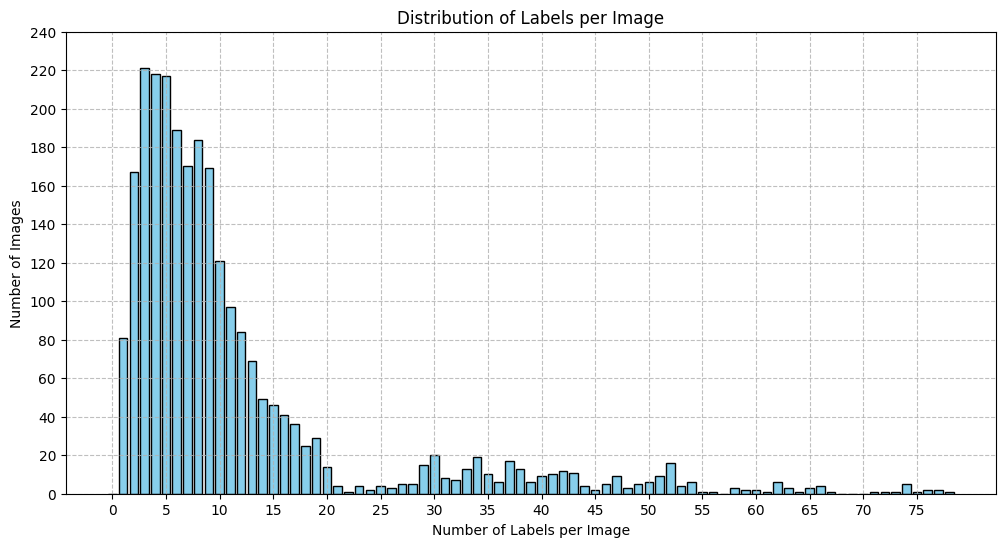

In [145]:
plt.figure(figsize=(12, 6))
plt.bar(value_counts.keys(), value_counts.values(), color='skyblue', edgecolor = 'black')
plt.xlabel("Number of Labels per Image")
plt.ylabel("Number of Images")
plt.xticks(np.arange(0, 80, step=5))
plt.yticks(np.arange(0, 241, step = 20))
plt.title("Distribution of Labels per Image")
plt.grid(linestyle="--", alpha=0.8)
plt.show()


2. ## Calculate the statistics of the area of solar panels in meters

- ### What method was used to compute the area (in meters) for a single instance?

##### The label of a single instance contains 5 values [class_id, x_center, y_center, width, height]
##### To compute the area of a single instance:
- ##### Calculate the height, width of the instance in pixels :
    - ###### width_in_pixels = width * 416
    - ###### height_in_pixels = height * 416
- ##### Convert the height and width into real-world values by multiplying with resolution:
    - ###### width_in_meters = width_in_pixels * 0.31
    - ###### height_in_meters = height_in_pixels * 0.31
#####
##### Calculate the area of the instance by multiplying width and height:
##### Area = height_in_meters * weight_in_meters

In [4]:
def compute_area_instance(label):
    _, _, _, width, height = map(float, line.strip().split())

    width_in_pixels = width * image_size
    height_in_pixels = height * image_size

    width_in_meters = width_in_pixels * resolution
    height_in_meters = height_in_pixels * resolution

    area = width_in_meters * height_in_meters

    return area

- ### What is the mean area and standard deviation?

In [7]:
print(f"The mean area of instances is {round(mean_area, 4)}")
print(f"The Standard Deviation is {sd_area:.4f}")

The mean area of instances is 191.5178
The Standard Deviation is 630.7004


- ### Plot the histogram of areas. What do you observe? 

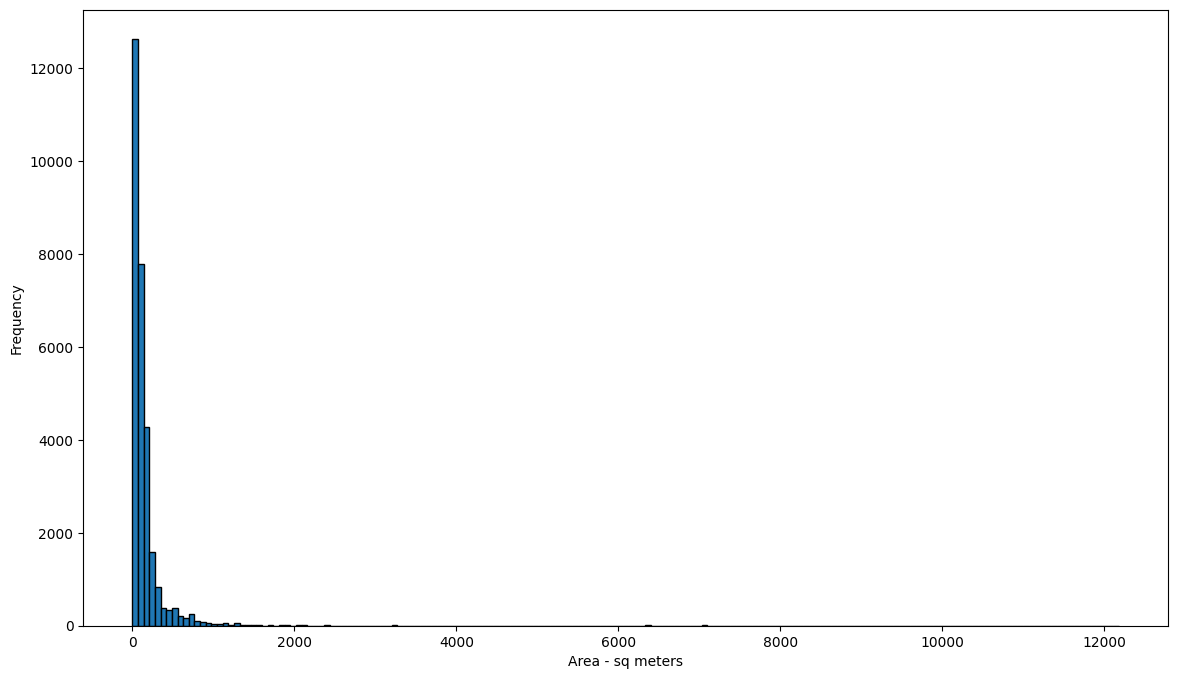

In [8]:
plt.figure(figsize = (14, 8))

plt.hist(instances_area, bins = 175, edgecolor = "black")
plt.xlabel("Area - sq meters")
plt.ylabel("Frequency")
plt.show()

- From the histogram we can say that it a right-skewed distribution
- Most of the solar panels in the dataset are smaller size solar panels
- Also we can see the long tail effect, due to very few large area solar panels(outliers). 

# Implementing the Fundamental Functions

1. ### Write a function to compute IoU (Intersection over Union) between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using supervision library 

In [150]:
# Creating bounding box in pixel coordinates
def create_box(x_center, y_center, width, height, img_size=416):
    x_start = (x_center - width / 2) * img_size
    x_end = (x_center + width / 2) * img_size
    y_start = (y_center - height / 2) * img_size  
    y_end = (y_center + height / 2) * img_size 

    return (x_start, y_start, x_end, y_end)

In [10]:
# Calculating IoU using the Shapely library
def iou_shapely(box1, box2):
    shapely_box1 = sp.geometry.box(*box1)  # Creating bounding box1
    shapely_box2 = sp.geometry.box(*box2)  # Creating bounding box2

    box_intersection = shapely_box1.intersection(shapely_box2).area  # Area of intersection
    box_union = shapely_box1.union(shapely_box2).area  # Area of union

    iou = box_intersection / box_union if box_union > 0 else 0.0  # Compute IoU
    return iou

In [148]:
# Calculating IoU using the Supervision library
def iou_supervision(box1, box2):
    arr1 = np.array(box1).reshape(1, 4)  
    arr2 = np.array(box2).reshape(1, 4) 
    iou = sv.box_iou_batch(arr1, arr2)  # Compute IoU using supervision
    return iou[0, 0] 

In [12]:
# Example bounding boxes (center_x, center_y, width, height)
box1 = (0.9, 0.5, 0.5, 0.5)
box2 = (0.3, 0.6, 0.8, 0.7)

# Convert to pixel coordinates
box1 = create_box(*box1)
box2 = create_box(*box2)

# Compute IoU values
shapely_values = iou_shapely(box1, box2)
supervision_values = iou_supervision(box1, box2)

# Print results
print(f"IOU using Shapely Library : {shapely_values}")
print(f"IOU using Supervision Library : {supervision_values}")
print(f"Are the results similar? {np.isclose(shapely_values, supervision_values)}")

IOU using Shapely Library : 0.03184713375796171
IOU using Supervision Library : 0.031847133757961714
Are the results similar? True


2. ## Write a function to compute Average Precision (AP)

- ### Use Pascal VOC 11 point interpolation method to implement the function 

In [13]:
def compute_voc11(precision, recalls):
    avg_precision = 0.0
    recall_levels = np.linspace(0, 1, 11)

    for level in recall_levels:
        curr_max = max(precision[recalls >= level]) if np.any(recalls >= level) else 0
        avg_precision += curr_max

    return avg_precision / 11

- ### Use COCO 101-point interpolation method to implement the function


In [14]:
def compute_coco101(precision, recalls):
    avg_precision = 0.0
    recall_levels = np.linspace(0, 1, 101)

    for level in recall_levels:
        curr_max = max(precision[recalls >= level]) if np.any(recalls >= level) else 0
        avg_precision += curr_max

    return avg_precision / 101

- ### Use Area under Precision-Recall Curve (AP) method to implement the function 

In [102]:
def compute_auc(precision_values, recall_values):
    # Ensure values are in [0,1] range
    precision_values = np.clip(precision_values, 0, 1)
    recall_values = np.clip(recall_values, 0, 1)
    
    # Compute AUC using trapezoidal rule
    auc_score = np.trapz(precision_values, recall_values)
    
    return auc_score 

### Computing the precision and recall values for implementation of above functions

In [149]:
# function to generate precisions and recall values for the calculation of Average Precision

def generate_precision_recall(predicted_boxes, ground_truths, iou_threshold=0.5):
    
    tp, fp, fn = 0, 0, len(ground_truths) # True Positives, False Positives,  False Negatives
    precision_values, recall_values = [], []

    for pred_box, _ in predicted_boxes:

        curr_max = 0
        
        for gt in ground_truths:
            curr_max = max(curr_max, iou_shapely(pred_box, gt))

        if curr_max >= iou_threshold:
            tp += 1
            fn -= 1
        else:
            fp += 1
    
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_values.append(precision)
        recall_values.append(recall)

    return np.array(precision_values), np.array(recall_values)

- ### Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods

In [17]:
#generating random boxes within the lengths of the image

np.random.seed(42)

def generate_random_boxes(number_of_boxes, img_size, box_size):
    boxes = []
    for _ in range(number_of_boxes):
        x1 = np.random.randint(0, img_size - box_size)
        y1 = np.random.randint(0, img_size - box_size)
        x2 = x1 + box_size
        y2 = y1 + box_size
        boxes.append((x1, y1, x2, y2))
    return boxes


In [18]:
#computing the average precision using the three methods(voc11, coco101, auc for the random generated boxes, ground-truths in the randomly generated images)
voc_11_values, coco_101_values, auc_values = [], [], []
number_of_images = 10

for _ in range(number_of_images):
    ground_truth_boxes = generate_random_boxes(10, 100, 20)
    predicted_truth_boxes = [(box, np.random.rand()) for box in generate_random_boxes(10, 100, 20)] # array contains((box_co-ordinates), confidence_levels) as the boxes are generated randomly the confidence levels are also generated randomly

    predicted_truth_boxes.sort(key=lambda x: x[1], reverse=True) #sorting the boxes in descending order of their confidence levels

    precision_values, recall_values = generate_precision_recall(predicted_truth_boxes, ground_truth_boxes) #genrating the precision, recalls for the randomly generated predicted boxes and ground truths

    pascal_ap = compute_voc11(precision_values, recall_values)
    coco_ap = compute_coco101(precision_values, recall_values)
    auc_ap = compute_auc(precision_values, recall_values)

    voc_11_values.append(pascal_ap)
    coco_101_values.append(coco_ap)
    auc_values.append(auc_ap)

print(f"AP50 (Average Precision at IOU 0.5) using Pascal VOC 11 point interpolation method: {np.mean(voc_11_values)}")
print(f"AP50 (Average Precision at IOU 0.5) using COCO 101-point interpolation method: {np.mean(coco_101_values)}")
print(f"AP50 (Average Precision at IOU 0.5) using Area under Precision-Recall Curve (AP) method: {np.mean(auc_values)}")

AP50 (Average Precision at IOU 0.5) using Pascal VOC 11 point interpolation method: 0.04769119769119769
AP50 (Average Precision at IOU 0.5) using COCO 101-point interpolation method: 0.04180418041804181
AP50 (Average Precision at IOU 0.5) using Area under Precision-Recall Curve (AP) method: 0.02450198412698413


#### From the above Average Precision calculated using various methods, COCO-101 point interpolation method has given the best AP50 for randomly generated images.
#### The order of methods in ascending order of AP50 calculated is :
- ##### Area Under Precision-Recall Curve Method
- ##### Pascal VOC 11 point interpolation method
- ##### COCO 101-point interpolation method

# Model building and evaluation 

## Split the data into 80-20 train-test split. Use 10% of training data as validation.

In [19]:
os.makedirs("Outputs/images/train", exist_ok = True)
os.makedirs("Outputs/images/valid", exist_ok = True)
os.makedirs("Outputs/images/test", exist_ok = True)
os.makedirs("Outputs/labels/train", exist_ok = True)
os.makedirs("Outputs/labels/valid", exist_ok = True)
os.makedirs("Outputs/labels/test", exist_ok = True)

In [20]:
#extracting the images and labels from the directories
label_files = sorted([f for f in os.listdir(labels) if f.endswith(".txt")])
image_files = sorted([f for f in os.listdir(images) if f.endswith(".tif") and (f[:-4] + ".txt") in label_files])

In [102]:
pip install ultralytics

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/921.5 kB ? eta -:--:--
   ---------------------------------------- 921.5/921.5 kB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.6 MB 4.5 MB/s eta 0:00:03
   ----- ---------------------------------- 1.8/12.6 MB 4.0 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/12.6 MB 3.1 MB/s eta 0:00:04
   ---------- ----------------------------- 3.1/12.6 MB 3.7 MB/s eta 0:00:03
   ------------ --------------------------- 3.9/12.6 MB 3.7 MB/s eta 0:00:03
   --------------- ------------------------ 5.0/12.6 MB 3.8 MB/s eta 0:00:03
   ------------------ --------------------- 5.8/12.6 MB 3.8 MB/s eta 0:00:02
   -------------------- ------------------- 6.6/12

  You can safely remove it manually.
  You can safely remove it manually.


In [21]:
#Splitting of data to 80% train data(90% train data, 10% validation data), 20% test data 

train_img, test_img = train_test_split(image_files, test_size = 0.2, random_state = 42)
train_img, valid_img = train_test_split(train_img, test_size = 0.1, random_state = 42)

In [22]:

def move_files(files, img_src, label_src, img_dest, label_dest):
    label_files = os.listdir(label_src)  # Get all available label files

    for file in files:
        label_file = file.replace(".tif", ".txt")  # Convert image filename to label filename

        img_path = os.path.join(img_src, file)
        label_path = os.path.join(label_src, label_file)

        shutil.copy(img_path, os.path.join(img_dest, file))
        shutil.copy(label_path, os.path.join(label_dest, label_file))

move_files(train_img, images, labels, "Outputs/images/train", "Outputs/labels/train")
move_files(valid_img, images, labels, "Outputs/images/valid", "Outputs/labels/valid")
move_files(test_img, images, labels, "Outputs/images/test", "Outputs/labels/test")

In [23]:
yaml_string = """path: Outputs

train: images/train
val: images/valid
test: images/test

nc : 3
names: ['label-1', 'label-2', 'label-3']"""

with open("Outputs/data.yaml", 'w') as file:
    file.write(yaml_string)

- ### Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged. 

In [133]:
# training the YOLOv11 model with the dataset
model = YOLO("yolo11n.pt")

results = model.train(data="Outputs/data.yaml", epochs=75, imgsz=416)

100%|█████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:01<00:00, 3.69MB/s]


New https://pypi.org/project/ultralytics/8.3.79 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.78  Python-3.13.1 torch-2.6.0+cpu CPU (AMD Ryzen 5 5600H with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=Outputs/data.yaml, epochs=75, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning C:\Users\Piyush\Downloads\Task-SRIP\Outputs\labels\train.cache... 1829 images, 0 backgrounds, 0 corrupt
val: Scanning C:\Users\Piyush\Downloads\Task-SRIP\Outputs\labels\valid.cache... 204 images, 0 backgrounds, 0 corrupt: 1


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75         0G      1.938      2.489      1.316        139        416: 100%|██████████| 115/115 [05:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:35<0

                   all        204       2344      0.828      0.174      0.165     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75         0G      1.513      1.204      1.116        113        416: 100%|██████████| 115/115 [04:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<0

                   all        204       2344      0.926       0.22      0.255      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75         0G      1.466      1.097      1.097         50        416: 100%|██████████| 115/115 [04:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<0

                   all        204       2344      0.908      0.222      0.242      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75         0G      1.418      1.031      1.094         83        416: 100%|██████████| 115/115 [04:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<0

                   all        204       2344      0.927      0.244      0.274       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75         0G       1.38     0.9957      1.069        119        416: 100%|██████████| 115/115 [04:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<0

                   all        204       2344      0.903      0.238      0.257      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75         0G      1.343     0.9368      1.055         27        416: 100%|██████████| 115/115 [04:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<0

                   all        204       2344       0.94      0.248      0.278      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75         0G      1.322     0.9008      1.052        122        416: 100%|██████████| 115/115 [04:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<0

                   all        204       2344      0.937      0.257      0.285      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75         0G      1.306     0.8863      1.051         85        416: 100%|██████████| 115/115 [04:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<0

                   all        204       2344      0.936       0.26       0.28      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75         0G      1.265     0.8511      1.031        114        416: 100%|██████████| 115/115 [04:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<0

                   all        204       2344      0.921      0.258      0.267      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75         0G      1.259     0.8474      1.025        171        416: 100%|██████████| 115/115 [04:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<0

                   all        204       2344      0.929      0.266      0.287      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75         0G      1.243      0.815      1.016         60        416: 100%|██████████| 115/115 [04:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<0

                   all        204       2344      0.949      0.273      0.294      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75         0G      1.247      0.801      1.013         67        416: 100%|██████████| 115/115 [04:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<0

                   all        204       2344       0.95      0.264      0.293      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75         0G      1.203     0.7878     0.9952         50        416: 100%|██████████| 115/115 [13:11<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344       0.96      0.272      0.305      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75         0G      1.183     0.7665     0.9932        122        416: 100%|██████████| 115/115 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344       0.95      0.263      0.295      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75         0G      1.194     0.7776     0.9988        102        416: 100%|██████████| 115/115 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.934      0.269       0.29      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75         0G      1.181     0.7661      0.989         59        416: 100%|██████████| 115/115 [03:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.955      0.281      0.306      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75         0G      1.175     0.7534     0.9972         55        416: 100%|██████████| 115/115 [03:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.947       0.27      0.295      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75         0G      1.146     0.7312     0.9874         74        416: 100%|██████████| 115/115 [03:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.955      0.281      0.308      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75         0G      1.131      0.719     0.9763        102        416: 100%|██████████| 115/115 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.946      0.274      0.301      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75         0G      1.106     0.6948     0.9715         93        416: 100%|██████████| 115/115 [03:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<0

                   all        204       2344      0.963      0.287      0.315      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75         0G      1.115     0.6989     0.9708         57        416: 100%|██████████| 115/115 [03:50<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.965      0.281      0.323      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75         0G      1.099     0.6876     0.9656         89        416: 100%|██████████| 115/115 [03:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.957      0.279      0.327      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75         0G        1.1     0.6907     0.9601         95        416: 100%|██████████| 115/115 [03:47<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<0

                   all        204       2344      0.964      0.279      0.315      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75         0G      1.093     0.6822     0.9635         65        416: 100%|██████████| 115/115 [03:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.963      0.284      0.314      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75         0G      1.096     0.6771     0.9651         80        416: 100%|██████████| 115/115 [03:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.967      0.286      0.336      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75         0G      1.079     0.6729     0.9611         63        416: 100%|██████████| 115/115 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<0

                   all        204       2344      0.744      0.327      0.337      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75         0G      1.064     0.6562     0.9556         43        416: 100%|██████████| 115/115 [03:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.968      0.286      0.321      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75         0G      1.045     0.6443     0.9512         40        416: 100%|██████████| 115/115 [03:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.648      0.338      0.354      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75         0G      1.064     0.6532     0.9529         33        416: 100%|██████████| 115/115 [03:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344       0.64      0.331      0.344      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75         0G      1.028     0.6397     0.9463        108        416: 100%|██████████| 115/115 [03:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.969      0.288      0.349      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75         0G      1.046     0.6461      0.951         73        416: 100%|██████████| 115/115 [03:48<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<0

                   all        204       2344      0.958       0.29      0.334      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75         0G      1.052      0.639     0.9486         26        416: 100%|██████████| 115/115 [04:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<0

                   all        204       2344      0.774      0.329      0.384      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75         0G      1.033     0.6291     0.9499         96        416: 100%|██████████| 115/115 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.969      0.291      0.373       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75         0G      1.024     0.6249     0.9423        149        416: 100%|██████████| 115/115 [03:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.931      0.359      0.409       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75         0G      1.029     0.6241     0.9415         85        416: 100%|██████████| 115/115 [03:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.791      0.363      0.395      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75         0G      1.029     0.6282     0.9454        116        416: 100%|██████████| 115/115 [03:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.755      0.329      0.381       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75         0G      1.025     0.6226     0.9396         34        416: 100%|██████████| 115/115 [04:11<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<0

                   all        204       2344      0.945      0.339      0.421      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75         0G     0.9959     0.6063     0.9346         48        416: 100%|██████████| 115/115 [13:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<0

                   all        204       2344      0.637      0.407      0.425      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75         0G      1.006     0.6116     0.9346         88        416: 100%|██████████| 115/115 [03:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.915      0.347      0.457      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75         0G      0.992     0.5991     0.9323         82        416: 100%|██████████| 115/115 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.597      0.418      0.446      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75         0G     0.9838     0.5931      0.929         80        416: 100%|██████████| 115/115 [03:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.625        0.4      0.431      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75         0G     0.9741       0.59     0.9306         26        416: 100%|██████████| 115/115 [03:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.627      0.428      0.441      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75         0G     0.9712     0.5872     0.9273         52        416: 100%|██████████| 115/115 [03:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.532      0.413      0.453      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75         0G     0.9703     0.5864      0.932        113        416: 100%|██████████| 115/115 [03:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344       0.52      0.408      0.455       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75         0G     0.9683     0.5833     0.9272        163        416: 100%|██████████| 115/115 [03:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.682      0.485      0.516      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75         0G     0.9514     0.5724     0.9228         71        416: 100%|██████████| 115/115 [03:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.623      0.488      0.546      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75         0G     0.9463     0.5671     0.9191         42        416: 100%|██████████| 115/115 [03:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.809      0.389      0.498      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75         0G     0.9442     0.5679     0.9208         36        416: 100%|██████████| 115/115 [03:27<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.805      0.432      0.481      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75         0G     0.9332     0.5615     0.9173         35        416: 100%|██████████| 115/115 [03:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.821      0.443      0.514       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75         0G      0.943     0.5631     0.9144        125        416: 100%|██████████| 115/115 [03:27<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.588      0.628      0.591      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75         0G     0.9302     0.5598     0.9158        115        416: 100%|██████████| 115/115 [03:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.787      0.454      0.529      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75         0G     0.9267      0.556     0.9133         88        416: 100%|██████████| 115/115 [03:46<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.897      0.443      0.538      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75         0G     0.9277     0.5506       0.91         65        416: 100%|██████████| 115/115 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.963      0.518      0.609      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75         0G      0.908     0.5449     0.9084        115        416: 100%|██████████| 115/115 [03:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.846      0.524      0.642      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75         0G     0.9029     0.5411     0.9069         42        416: 100%|██████████| 115/115 [03:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.922      0.494      0.635       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75         0G     0.9066     0.5419     0.9116         33        416: 100%|██████████| 115/115 [03:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.655      0.623      0.637      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75         0G        0.9     0.5409     0.9099         54        416: 100%|██████████| 115/115 [03:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.723       0.57       0.63      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75         0G      0.889     0.5338     0.9072         61        416: 100%|██████████| 115/115 [03:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.913      0.574       0.66      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75         0G     0.8866     0.5281     0.9036         39        416: 100%|██████████| 115/115 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.828       0.62      0.674        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75         0G     0.8667     0.5206      0.899         49        416: 100%|██████████| 115/115 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344       0.92      0.576       0.68      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75         0G     0.8815     0.5267     0.9054         48        416: 100%|██████████| 115/115 [03:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.589      0.642      0.652      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75         0G     0.8559     0.5147     0.8953         89        416: 100%|██████████| 115/115 [03:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.915      0.616      0.701      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75         0G     0.8502     0.5119     0.8947         59        416: 100%|██████████| 115/115 [03:27<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<0

                   all        204       2344      0.866      0.637      0.705       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75         0G       0.86     0.5184     0.8981        116        416: 100%|██████████| 115/115 [03:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<0

                   all        204       2344      0.779      0.661      0.689      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75         0G     0.8587     0.5138     0.8964         53        416: 100%|██████████| 115/115 [03:26<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.875      0.641      0.712      0.519


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75         0G     0.8033     0.4859     0.8834         68        416: 100%|██████████| 115/115 [03:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344        0.8      0.625      0.728       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75         0G     0.7874     0.4741     0.8748         32        416: 100%|██████████| 115/115 [03:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<0

                   all        204       2344      0.754      0.676      0.747      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75         0G     0.7758     0.4655     0.8714         22        416: 100%|██████████| 115/115 [03:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<0

                   all        204       2344      0.774      0.739      0.762      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75         0G     0.7675     0.4644     0.8762         52        416: 100%|██████████| 115/115 [03:27<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.931      0.664      0.778       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75         0G     0.7666     0.4576     0.8716         15        416: 100%|██████████| 115/115 [03:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.901       0.64      0.773      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75         0G     0.7607     0.4569     0.8744         65        416: 100%|██████████| 115/115 [03:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.919      0.717        0.8      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75         0G     0.7662     0.4584     0.8706         26        416: 100%|██████████| 115/115 [03:27<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.918      0.739      0.794      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75         0G     0.7465     0.4495     0.8704         43        416: 100%|██████████| 115/115 [03:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.933      0.739      0.795      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75         0G     0.7372     0.4473     0.8666         76        416: 100%|██████████| 115/115 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<0

                   all        204       2344      0.876      0.758      0.795      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75         0G      0.738     0.4448     0.8638         76        416: 100%|██████████| 115/115 [03:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<0

                   all        204       2344      0.894      0.758      0.793      0.555



75 epochs completed in 5.280 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 5.4MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.78  Python-3.13.1 torch-2.6.0+cpu CPU (AMD Ryzen 5 5600H with Radeon Graphics)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<0


                   all        204       2344      0.878      0.758      0.795      0.558
               label-1        204       2314      0.886      0.953      0.971      0.786
               label-2         12         17      0.856      0.706      0.737      0.493
               label-3         13         13      0.891      0.615      0.677      0.393
Speed: 1.1ms preprocess, 38.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\train3


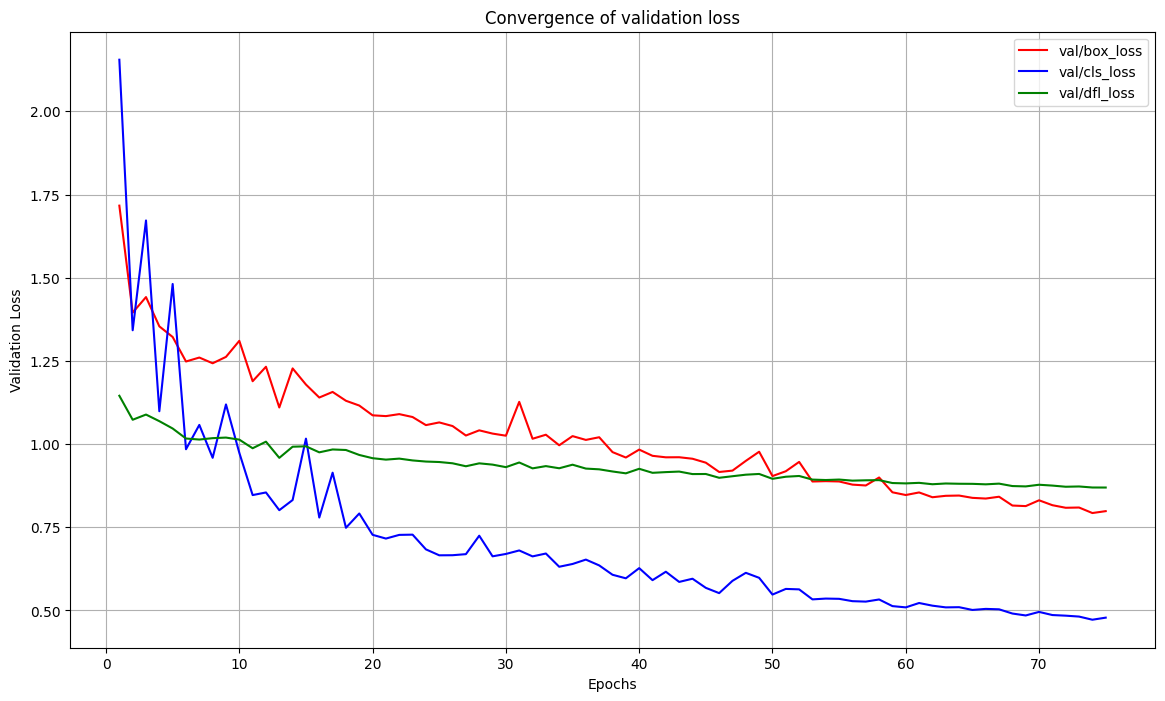

In [24]:
#calidation loss convergence graph

path = "runs/detect/train3/results.csv"
df = pd.read_csv(path)

plt.figure(figsize = (14, 8))

plt.plot(df['epoch'], df['val/box_loss'], color = "red")
plt.plot(df['epoch'], df['val/cls_loss'], color = "blue")
plt.plot(df['epoch'], df['val/dfl_loss'], color = "green")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Convergence of validation loss")
plt.legend(['val/box_loss', 'val/cls_loss', 'val/dfl_loss'])
plt.grid()

plt.show()

- ## Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels. 

In [25]:
test_images = os.listdir("Outputs/images/test")
test_images = [test_images[rd.randint(0, len(test_images))] for _ in range(0, 4)]
model = YOLO("runs/detect/train3/weights/best.pt")


image 1/1 C:\Users\Piyush\Downloads\Task-SRIP\Outputs\images\test\solarpanels_native_1__x0_8107_y0_12193_dxdy_416.tif: 416x416 25 label-1s, 170.2ms
Speed: 7.0ms preprocess, 170.2ms inference, 12.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\Piyush\Downloads\Task-SRIP\Outputs\images\test\solarpanels_native_1__x0_7255_y0_10894_dxdy_416.tif: 416x416 3 label-1s, 57.7ms
Speed: 1.2ms preprocess, 57.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\Piyush\Downloads\Task-SRIP\Outputs\images\test\solarpanels_native_3__x0_10297_y0_6927_dxdy_416.tif: 416x416 3 label-1s, 59.0ms
Speed: 1.2ms preprocess, 59.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\Piyush\Downloads\Task-SRIP\Outputs\images\test\solarpanels_native_1__x0_235_y0_7779_dxdy_416.tif: 416x416 7 label-1s, 1 label-3, 56.6ms
Speed: 1.2ms preprocess, 56.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


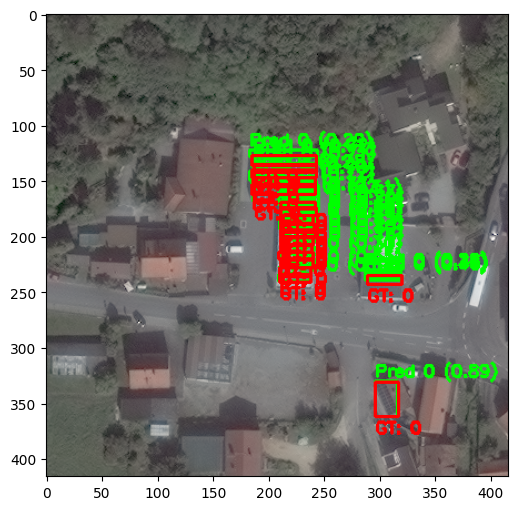

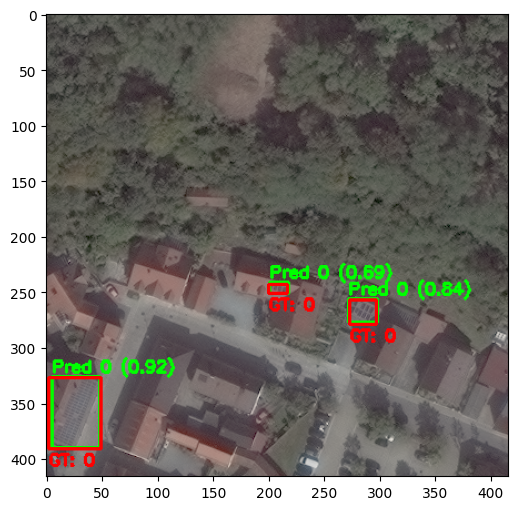

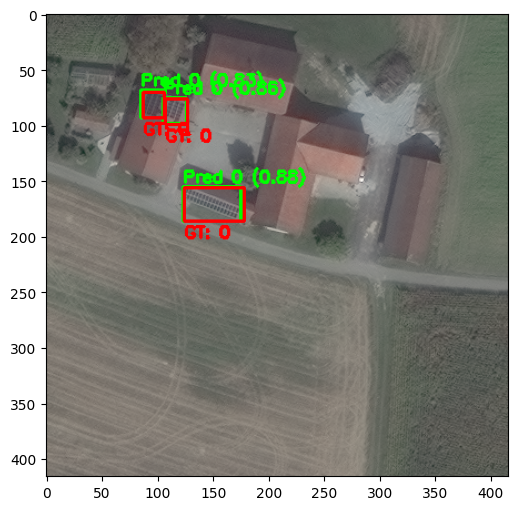

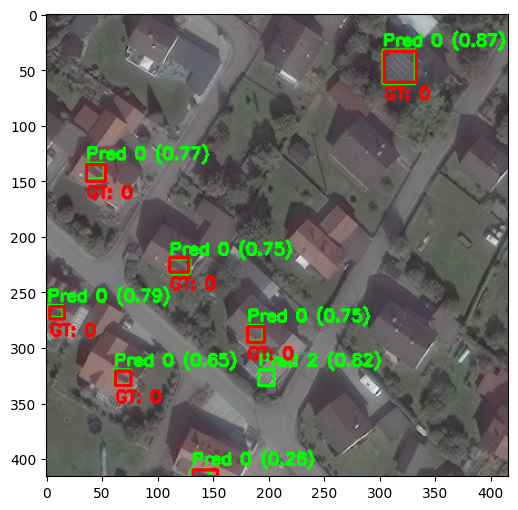

In [26]:
def draw_boxes(path, label_path, pred_box=None, gt_box=None):
    curr_img = cv2.imread(path)
    curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2RGB)

    # Get predictions from YOLO model
    pred_box = model(path)[0].boxes.data.cpu().numpy()

    # Draw predicted bounding boxes (Green)
    for box in pred_box:
        x_start, y_start, x_end, y_end, _,  cls = map(int, box[:6])  # Convert to integers
        cf_level = box[4]
        cv2.rectangle(curr_img, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)  # Green for predictions
        cv2.putText(curr_img, f"Pred {int(cls)} ({cf_level:.2f})", (x_start, y_start - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    with open(label_path, "r") as file:
        lines = file.readlines()

        for line in lines:
            cls, x_center, y_center, width, height = map(float, line.strip().split())
            x1 = int((x_center - width / 2) * 416)
            x2 = int((x_center + width / 2) * 416)
            y1 = int((y_center - height / 2) * 416)
            y2 = int((y_center + height / 2) * 416)

            color = (255, 0, 0)

            cv2.rectangle(curr_img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(curr_img, f"GT: {int(cls)}", (x1, y2 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    plt.figure(figsize = (8, 6))
    plt.imshow(curr_img)

# Example usage (update test image path)
for img in test_images:
    test_image_path = "Outputs/images/test/" + img
    test_label_path = "Outputs/labels/test/" + img[:-4] + ".txt"
    draw_boxes(test_image_path, test_label_path)

## Use supervision.metrics functionality from supervision library to compute the following metrics.


   - ### Compute mAP50 with supervision and compare with your implementation. What do you observe

In [146]:
def compute_pred_gt(test_img, model):
    ground_truths = []
    predictions = []
    
    pred_box_data = []
    gt_box_data = []
    
    for image in test_img:
        path = f"Outputs/images/test/{image}"
    
        # Getting predictions from YOLO model
        pred_box = model(path)[0].boxes.data.cpu().numpy()
        
        pred_boxes = []
        pred_confidences = []
        pred_classes = []
    
        # Processing predicted bounding boxes
        for box in pred_box:
            x1, y1, x2, y2 = map(int, box[:4])  # Get bounding box coordinates
            conf = float(box[4])  # Confidence score
            class_id = int(box[5])  # Class label
    
            pred_boxes.append([x1, y1, x2, y2])
            pred_confidences.append(conf)
            pred_classes.append(class_id)
            pred_box_data.append([x1, y1, x2, y2, conf])
    
        # Storing predictions for this image
        pred_data = sv.Detections(
            xyxy=np.array(pred_boxes) if pred_boxes else np.empty((0, 4)),
            confidence=np.array(pred_confidences) if pred_confidences else np.empty((0,)),
            class_id=np.array(pred_classes) if pred_classes else np.empty((0,))
        )
        predictions.append(pred_data)
    
        # Processing ground truths
        label_path = f"Outputs/labels/test/{image.replace('.tif', '.txt')}" 
        gt_boxes = []
        gt_classes = []
    
        with open(label_path, "r") as file:
            lines = file.readlines()
    
            for line in lines:
                cls, x_center, y_center, width, height = map(float, line.strip().split())
                x1 = int((x_center - width / 2) * 416)
                x2 = int((x_center + width / 2) * 416)
                y1 = int((y_center - height / 2) * 416)
                y2 = int((y_center + height / 2) * 416)
    
                gt_boxes.append([x1, y1, x2, y2])
                gt_classes.append(int(cls))
                gt_box_data.append([x1, y1, x2, y2, 1.0])
    
        # Storing ground truths for this image
        gt_data = sv.Detections(
            xyxy=np.array(gt_boxes) if gt_boxes else np.empty((0, 4)),
            confidence=np.ones(len(gt_boxes)) if gt_boxes else np.empty((0,)),
            class_id=np.array(gt_classes) if gt_classes else np.empty((0,))
        )
        ground_truths.append(gt_data)
        
    return predictions, ground_truths, pred_box_data, gt_box_data
    
# Computing mAP@50 using Supervision
evaluator = sv.metrics.MeanAveragePrecision()  # IoU threshold 50%

predictions, ground_truths, pred_box_data, gt_box_data = compute_pred_gt(test_img, model)

evaluator.update(predictions, ground_truths)
map_50_supervision = evaluator.compute()

print(f"mAP50 using Supervision: {map_50_supervision}")


image 1/1 C:\Users\Piyush\Downloads\Task-SRIP\Outputs\images\test\solarpanels_native_3__x0_10105_y0_14149_dxdy_416.tif: 416x416 3 label-1s, 60.0ms
Speed: 2.1ms preprocess, 60.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\Piyush\Downloads\Task-SRIP\Outputs\images\test\solarpanels_native_1__x0_7918_y0_11152_dxdy_416.tif: 416x416 7 label-1s, 32.1ms
Speed: 0.7ms preprocess, 32.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\Piyush\Downloads\Task-SRIP\Outputs\images\test\solarpanels_native_1__x0_5880_y0_13362_dxdy_416.tif: 416x416 9 label-1s, 32.8ms
Speed: 0.6ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\Piyush\Downloads\Task-SRIP\Outputs\images\test\solarpanels_native_2__x0_770_y0_10677_dxdy_416.tif: 416x416 58 label-1s, 35.8ms
Speed: 0.5ms preprocess, 35.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Users\Piy

In [104]:
def generate_precision_recall_values(predicted_boxes, ground_truths, iou_threshold=0.5):
    predicted_boxes = sorted(predicted_boxes, key=lambda x: x[4], reverse=True)

    tp, fp, fn = 0, 0, len(ground_truths)
    precision_values, recall_values = [], []

    matched_gt = set()  # Track used ground truth boxes

    for pred_box in predicted_boxes:
        max_iou = 0
        best_gt = None
        
        for gt_idx, gt_box in enumerate(ground_truths):
            iou = iou_shapely(pred_box[:4], gt_box[:4])
            if iou > max_iou:
                max_iou = iou
                best_gt = gt_idx  # Store the index of the best match
    
        if max_iou >= iou_threshold and best_gt not in matched_gt:
            tp += 1
            fn = max(fn - 1, 0)
            matched_gt.add(best_gt)  # Mark this GT as used
        else:
            fp += 1

        precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        precision_values.append(precision)
        recall_values.append(recall)


    return np.array(precision_values), np.array(recall_values)


In [105]:
# Initialize lists to store results
voc_11_values, coco_101_values, auc_values = [], [], []

precision_values, recall_values = generate_precision_recall_values(pred_box_data, gt_box_data)

pascal_ap = compute_voc11(precision_values, recall_values)
coco_ap = compute_coco101(precision_values, recall_values)
auc_ap = compute_auc(precision_values, recall_values)

voc_11_values.append(pascal_ap)
coco_101_values.append(coco_ap)
auc_values.append(auc_ap)

In [107]:
# Print final results
print(f"AP50 (Pascal VOC 11-point): {np.mean(voc_11_values)}")
print(f"AP50 (COCO 101-point): {np.mean(coco_101_values)}")
print(f"AP50 (AUC method): {np.mean(auc_values)}")

AP50 (Pascal VOC 11-point): 0.8951401649690862
AP50 (COCO 101-point): 0.9162023733623365
AP50 (AUC method): 0.9218922393394704


- ### Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] 

In [89]:
# Metric Computation
def compute_metrics(predictions, ground_truths, iou_thresholds, confidence_thresholds):
    res_dir = {}

    # Compute mAP50
    map_metric = sv.metrics.MeanAveragePrecision()
    for i in range(len(predictions)):
        map_metric.update(predictions[i], ground_truths[i])
    res_dir['map50'] = map_metric.compute().map50

    table_data = [] 

    for iou in iou_thresholds:
        for conf in confidence_thresholds:
            tp, fp, fn = 0, 0, 0

            for img in range(len(predictions)):
                pred_data = predictions[img]
                gt_data = ground_truths[img]

                # Apply confidence threshold
                mask = pred_data.confidence >= conf
                filtered_pred = sv.Detections(
                    xyxy=pred_data.xyxy[mask] if any(mask) else np.empty((0, 4)),
                    confidence=pred_data.confidence[mask] if any(mask) else np.array([]),
                    class_id=pred_data.class_id[mask] if any(mask) else np.array([])
                )

                if len(filtered_pred.xyxy) > 0 and len(gt_data.xyxy) > 0:
                    # Compute IoU for all pairs
                    ious = np.array([[iou_shapely(pred, gt) for gt in gt_data.xyxy] for pred in filtered_pred.xyxy])
                    
                    matches = ious >= iou

                    # True Positive
                    tp_curr = np.sum(np.any(matches, axis=1))

                    # False Positives
                    fp_curr = len(filtered_pred.xyxy) - tp_curr

                    # False Negatives
                    fn_curr = len(gt_data.xyxy) - np.sum(np.any(matches, axis=0))
                else:
                    tp_curr, fp_curr, fn_curr = 0, len(filtered_pred.xyxy), len(gt_data.xyxy)

                tp += tp_curr
                fp += fp_curr
                fn += fn_curr

            # Calculate metrics
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

            table_data.append({'IoU': iou, 'Confidence': conf, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score})

    # Convert to DataFrame
    df = pd.DataFrame(table_data)
    res_dir['metrics_df'] = df

    return res_dir

In [92]:
# Define thresholds and confidence for evaluation
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
confidence_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

# Computing metrics
results = compute_metrics(predictions, ground_truths, iou_thresholds, confidence_thresholds)


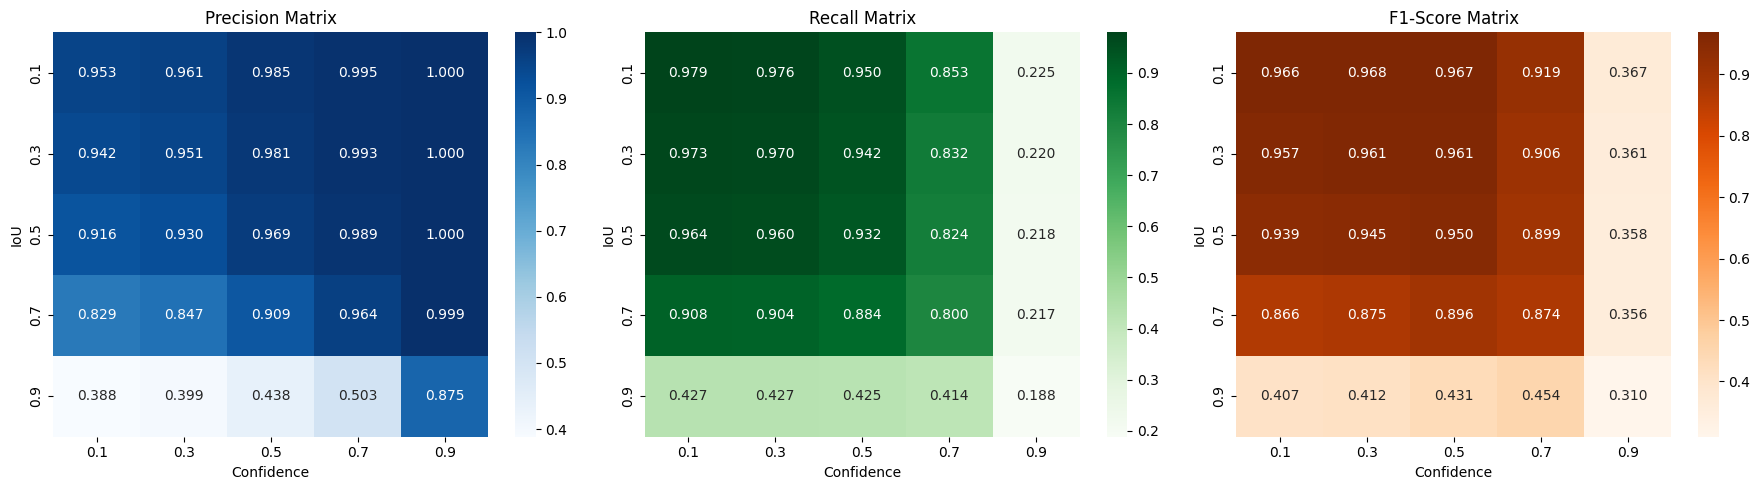

In [147]:
# Extract DataFrame
df = results['metrics_df']

# Pivot data for heatmaps
precision_matrix = df.pivot(index='IoU', columns='Confidence', values='Precision')
recall_matrix = df.pivot(index='IoU', columns='Confidence', values='Recall')
f1_matrix = df.pivot(index='IoU', columns='Confidence', values='F1-Score')

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(precision_matrix, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
axes[0].set_title("Precision Matrix")

sns.heatmap(recall_matrix, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
axes[1].set_title("Recall Matrix")

sns.heatmap(f1_matrix, annot=True, fmt=".3f", cmap="Oranges", ax=axes[2])
axes[2].set_title("F1-Score Matrix")

plt.tight_layout()
plt.show()
